In [1]:
%run tools.ipynb

In [23]:
# total CO2 simulation directory
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-test-2018/nd51/' + '/10x/'
sat_dir = '/geos/u73/msadiq/satellite/oco-2/'
year = 2018
month = 1
mode = 'N'
str1_mod = 'interpolated_2d_ts_satellite.'
str1_sat = '2d_OCO2_extract_'

#compare_XCO2(mod_dir, sat_dir, year, month, str1_mod, str1_sat, mode)

In [24]:
#
#def compare_XCO2(mod_dir, sat_dir, year, month, str1_mod, str1_sat, mode):
mod_file = str1_mod + str(year) + month_string(month) + '.nc'
sat_file = str1_sat + str(year) + month_string(month) + '.nc'
ds_mod = xr.open_dataset(mod_dir + mod_file)
ds_sat = xr.open_dataset(sat_dir + sat_file)
    
# mask data: predefined region, land vs. ocean, latitudinal bands
mask_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
mask_name     = 'flatten_mask.nc'
ds_mask = xr.open_dataset(mask_directory + mask_name)

avg_kern = ds_sat['xco2_averaging_kernel']
co2_pr   = ds_sat['co2_profile_apriori']
pres_wgt = ds_sat['pressure_weight']
op_mode  = ds_sat['operation_mode'] # 0=Nadir, 1=Glint
mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint

####
avg_kern[:,:] = 1.
####
# model simulated CO2 concentration
co2_model = ds_mod['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
co2_profile = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model


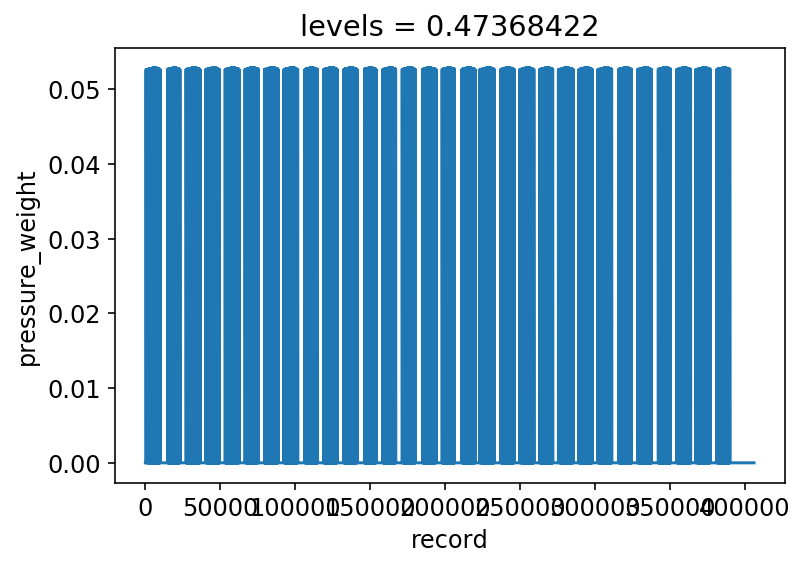

In [32]:
pres_wgt[:,9].plot()

R is: 0.63  RMSE is:  2.81


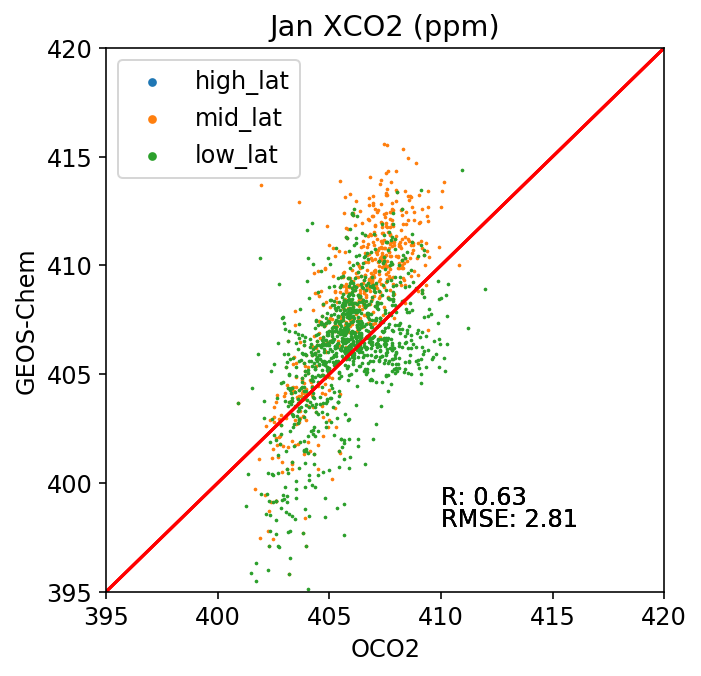

In [25]:
# sum up to get column CO2
xco2_model = co2_profile.sum(dim = 'levels')      # sum along vertical axis, unit: ppbv to ppm

xco2_model_mode = xco2_model * mode_mask # extract desired mode of observation: Nadir
xco2_oco2_mode = ds_sat['xco2'] * mode_mask

obs_series = xco2_oco2_mode.values
model_series = xco2_model_mode.values
obs_series[obs_series==0] = 'nan'
model_series[model_series==0] = 'nan'
    
R = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series))
x = obs_series[~np.isnan(obs_series)]
y = model_series[~np.isnan(model_series)]
rmse = np.sqrt(((y - x) ** 2).mean())
format_R = float("{0:.2f}".format(R[0,1]))
format_rmse = float("{0:.2f}".format(rmse))
print('R is:', format_R, ' RMSE is: ', format_rmse)

xco2_model_land = xco2_model_mode * ds_mask['land'][0:len(xco2_model)]
xco2_model_land[xco2_model_land==0] = 'nan'
xco2_oco2_land = xco2_oco2_mode * ds_mask['land'][0:len(xco2_model)]
xco2_oco2_land[xco2_oco2_land==0] = 'nan'

fig = plt.figure(figsize=[5,5])
name_month = short_name_of_month(month)
for region in ['high_lat', 'mid_lat', 'low_lat']:
    xco2_model_mask = xco2_model_land * ds_mask[region][0:len(xco2_model_land)]
    xco2_model_mask[xco2_model_mask==0] = 'nan'
    xco2_oco2_mask = xco2_oco2_land * ds_mask[region][0:len(xco2_model_land)]
    xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'

    plt.scatter(xco2_oco2_mask, xco2_model_mask, s=0.7, label = region)
    plt.plot([300,450],[300,450], c='r')
    plt.ylim(top   = 420,bottom = 395)
    plt.xlim(right = 420,left   = 395)
    plt.title(name_month + ' XCO2 (ppm)')
    plt.ylabel('GEOS-Chem')
    plt.xlabel('OCO2')
    plt.legend(markerscale = 4)

    plt.text(x=410, y=399, s='R: ' + str(format_R), size = 12)
    plt.text(x=410, y=398, s='RMSE: ' + str(format_rmse), size = 12)
    fig.savefig(mod_dir + '/mod_vs_obs_XCO2_latitudinal_'+ mode + '_' + name_month + '.png', dpi=300)

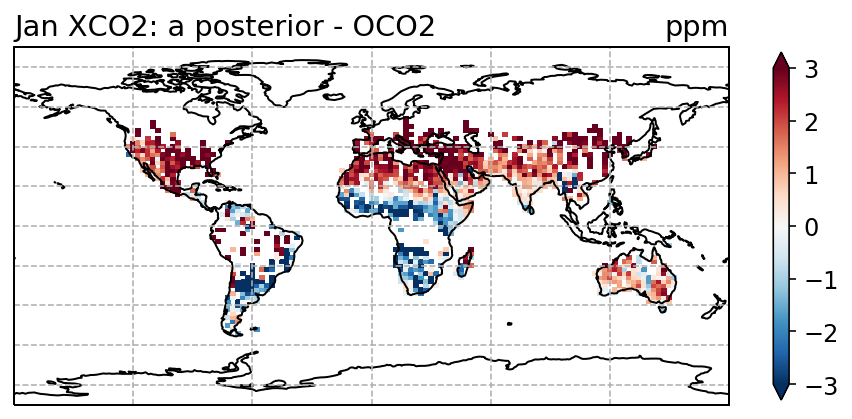

In [26]:
diff = xco2_oco2_land - xco2_model_land   # diff to calculate a posteriori
new_data = diff.to_dataset(name = 'diff')
new_data['xco2_oco2'] = xco2_oco2_land
new_data['xco2_model'] = xco2_model_land
new_data['xco2_error'] = ds_sat['xco2_uncertainty']
new_data['lat'] = ds_mod['lat']
new_data['lon'] = ds_mod['lon']
new_data['date'] = ds_mod['date']
new_data.to_netcdf(mod_dir + 'XCO2_mod_and_oco2_' + mode + '_' + name_month + '.nc')

# Creat target dataarray and dataset
lat_res = 2    # horizontal resolution of lat and lon you would want
lon_res = 2.5
lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
lon = np.linspace(-180, 177.5, int(360/lon_res))
days = len(diff)/(len(lat)*len(lon))

var_3d = xr.DataArray(data = np.nan, 
                          dims = ('days', 'lat', 'lon'), 
                          coords = {'days': range(int(days)),
                                    'lat': lat,
                                    'lon': lon},
                          name = 'diff')
var_3d = var_3d.astype(dtype='float32')

diff2 = xco2_model_land - xco2_oco2_land # diff to map onto global map
var_3d.values = diff2.values.reshape((int(days),len(lat),len(lon)))
    
var_2d = var_3d.mean(dim='days')
# plot after mapping
fig = plt.figure(figsize=[8, 8])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# 
var_2d.plot(ax=ax, vmax = 3, add_labels = False, cbar_kwargs={'shrink': 0.4})
ax.set_title(name_month + ' XCO2: a posterior - OCO2', loc = 'left');
ax.set_title('ppm', loc = 'right')
ax.coastlines()
ax.gridlines(linestyle = '--')
    

fig.savefig(mod_dir + 'diff_map_' + name_month + '.png', dpi=300)

ds_output = var_3d.to_dataset()
var_3d.values = xco2_model_land.values.reshape((int(days),len(lat),len(lon)))
ds_output['mod'] = var_3d.copy()
var_3d.values = xco2_oco2_land.values.reshape((int(days),len(lat),len(lon)))
ds_output['obs'] = var_3d.copy()
ds_output.to_netcdf(mod_dir + 'XCO2_diff_' + str(month) + '.nc')
